In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 70 #display 70 dpi in Jupyter Notebook, may consider100 dpi 
plt.rcParams['savefig.dpi'] = 70 #define 300 dpi for saving figures

import seaborn as sns
## here are some settings 
sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":70, 'savefig.dpi':70}) #defining dpi setting
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
# Tells matplotlib to display images inline instead of a new window
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

from time import time
import timeit #imports timeit module
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve

import sklearn.linear_model as skl_lm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeRegressor 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import export_graphviz
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from tqdm import tqdm
from lightgbm import LGBMClassifier

In [7]:
df = pd.read_csv('../RiverRoad_Quan_RF.csv')

In [66]:
def LGBM(X, y, gridid):
    fig, ax = plt.subplots()

    start_time = timeit.default_timer()

    kf = KFold(n_splits=5, random_state=2, shuffle=True)
    acc_score = [];
    Truth = [];
    Output = [];
    GRID_ID = pd.DataFrame(columns=['GRID_ID'])

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for i, (train_index , test_index) in tqdm(enumerate(kf.split(df))):
        X_train , X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train , y_test = y.iloc[train_index], y.iloc[test_index]
        train_grid = gridid.iloc[train_index]
        test_grid= gridid.iloc[test_index]

        model = LGBMClassifier(n_estimators=500, learning_rate=0.1, max_depth=6 ,random_state=2)

        model.fit(X_train, y_train)
        pred_values = model.predict(X_test)

        viz = plot_roc_curve(model, X_test, y_test,
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

        acc = accuracy_score(y_test, pred_values)
        acc_score.append(acc)

        GRID_ID = pd.merge(GRID_ID, test_grid, on='GRID_ID', how='outer')
        Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
        Output.extend(pred_values);

    elapsed = timeit.default_timer() - start_time

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="ROC for Light Gradient Boosting Model")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")

    output_df = pd.concat([GRID_ID, pd.DataFrame(Truth, columns=["Truth"]), pd.DataFrame(Output, columns=["Output"])], axis=1)
    return output_df, elapsed, confusion_matrix(Truth, Output), classification_report(Truth, Output, digits=4), acc_score, plt

## LGBM with all 60 columns

5it [00:11,  2.27s/it]


11.362431099998503 seconds
[0.9355774811375508, 0.9320557491289199, 0.9262485481997678, 0.9303135888501742, 0.9227642276422764]
0.9293919189917379 accuracy
[[2711  433]
 [ 175 5292]]
              precision    recall  f1-score   support

           0     0.9394    0.8623    0.8992      3144
           1     0.9244    0.9680    0.9457      5467

    accuracy                         0.9294      8611
   macro avg     0.9319    0.9151    0.9224      8611
weighted avg     0.9298    0.9294    0.9287      8611

<module 'matplotlib.pyplot' from 'C:\\Users\\shiti\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>


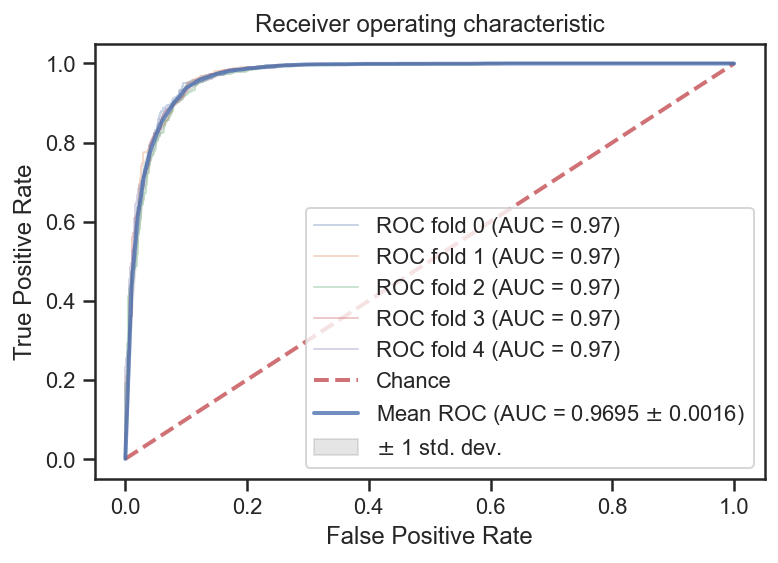

In [69]:
X = df.drop(['GRID_ID', 'wetland_type', 'wetland', 'FID_RiverRd_AOI'], axis=1)
y = df.FID_RiverRd_AOI
gridid = df.GRID_ID
output_df_60, time_60, cm_60, cr_60, acc_60, roc_60 = LGBM(X, y, gridid)
print(f"{time_60} seconds")
print(f"{acc_60}")
print(f"{np.mean(acc_60)} accuracy")
print(cm_60)
print(cr_60)
print(roc)

## LGBM with Asami's 24 columns(Interpretation)

5it [00:05,  1.04s/it]


5.20595460000186 seconds
[0.9408009286128846, 0.9303135888501742, 0.9250871080139372, 0.9279907084785134, 0.9303135888501742]
0.9309011845611368 accuracy
[[2730  414]
 [ 181 5286]]
              precision    recall  f1-score   support

           0     0.9378    0.8683    0.9017      3144
           1     0.9274    0.9669    0.9467      5467

    accuracy                         0.9309      8611
   macro avg     0.9326    0.9176    0.9242      8611
weighted avg     0.9312    0.9309    0.9303      8611

<module 'matplotlib.pyplot' from 'C:\\Users\\shiti\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>


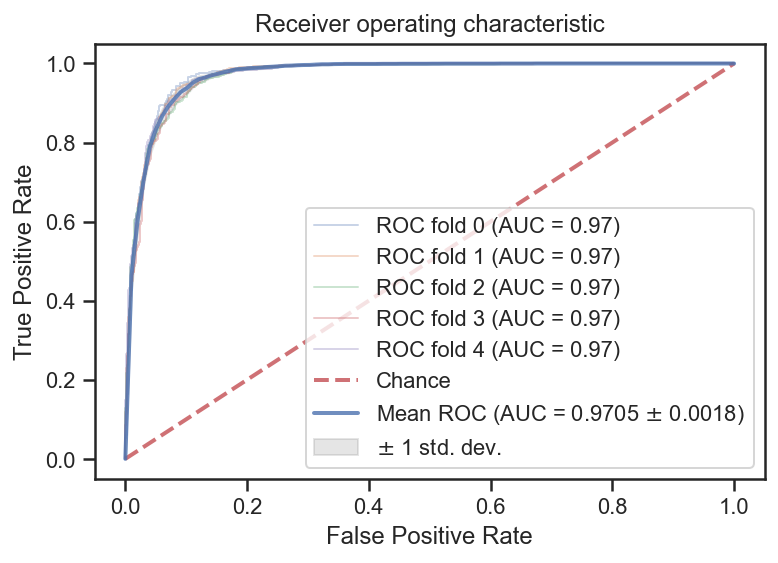

In [68]:
columns = ['qu_dsm_MAX',
'qu_hyddem_MIN',
'qu_dsm_MIN',
'qu_smdem_MAX',
'qu_dem_MIN',
'qu_dsm_SUM',
'qu_dsm_MEAN',
'qu_dsm_RANGE',
'qu_dsm_STD',
'qu_floAcu_MAX',
'qu_floAcu_STD',
'qu_hyddem_MAX',
'qu_dem_MAX',
'qu_floAcu_RANGE',
'qu_curpl_SUM',
'qu_hyddem_SUM',
'qu_curpl_MEAN',
'qu_hyddem_MEAN',
'qu_floAcu_MEAN',
'qu_curpl_STD',
'qu_floAcu_SUM',
'qu_smdem_MIN',
'qu_smdem_SUM',
'qu_curv_STD',
]
X = df[columns]
y = df.FID_RiverRd_AOI
gridid = df.GRID_ID
output_df_24, time_24, cm_24, cr_24, acc_24, roc_24 = LGBM(X, y, gridid)
print(f"{time_24} seconds")
print(f"{acc_24}")
print(f"{np.mean(acc_24)} accuracy")
print(cm_24)
print(cr_24)
print(roc)

## LGBM with Asami's 12 columns(Prediction)

5it [00:04,  1.07it/s]


4.680258000000322 seconds
[0.9408009286128846, 0.9256678281068524, 0.9303135888501742, 0.9291521486643438, 0.9262485481997678]
0.9304366084868045 accuracy
[[2735  409]
 [ 190 5277]]
              precision    recall  f1-score   support

           0     0.9350    0.8699    0.9013      3144
           1     0.9281    0.9652    0.9463      5467

    accuracy                         0.9304      8611
   macro avg     0.9316    0.9176    0.9238      8611
weighted avg     0.9306    0.9304    0.9299      8611

<module 'matplotlib.pyplot' from 'C:\\Users\\shiti\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>


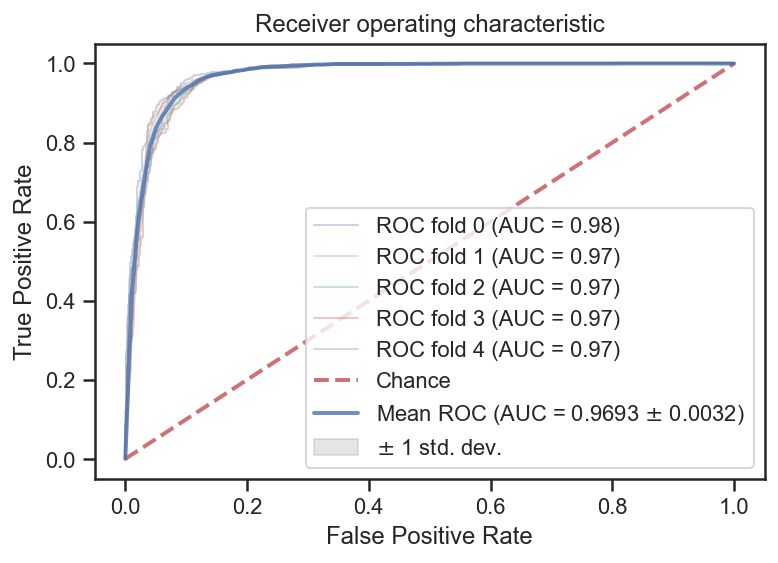

In [67]:
columns = [
'qu_dsm_MAX',
'qu_hyddem_MIN',
'qu_dsm_MIN',
'qu_smdem_MAX',
'qu_dem_MIN',
'qu_dsm_SUM',
'qu_dsm_STD',
'qu_floAcu_MAX',
'qu_floAcu_STD',
'qu_curpl_SUM',
'qu_curpl_STD',
'qu_floAcu_SUM',
]
X = df[columns]
y = df.FID_RiverRd_AOI
gridid = df.GRID_ID
output_df_12, time_12, cm_12, cr_12, acc_12, roc_12 = LGBM(X, y, gridid)
print(f"{time_12} seconds")
print(f"{acc_12}")
print(f"{np.mean(acc_12)} accuracy")
print(cm_12)
print(cr_12)
print(roc)

In [25]:
output_df_60.to_csv("../Comparison Data/LGBM60.csv", index=False)
output_df_24.to_csv("../Comparison Data/LGBM24.csv", index=False)
output_df_12.to_csv("../Comparison Data/LGBM12.csv", index=False)